In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate
from tqdm.notebook import tqdm

# Let's try the algorithm

First of all we select the middle class as outlier (label = 1) since it's a bit harder than the others.
In fact by being in the middle of the other two, the sphere projection must split.

In [5]:
classes = [1, 1, 1]

while sum(classes) <= 0 or sum(classes) >=3:
    classes = [random.choice([0, 1]) for _ in range(3)]
    
X = iris.data
y = [classes[0]] * 50 + [classes[1]] * 50 + [classes[2]] * 50
colors = ['red' if i == 1 else 'green' for i in y]

We scale the data and reduce the components to two, just to work in a easy to visualize environment.

In [6]:
X_scaled = MaxAbsScaler().fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)

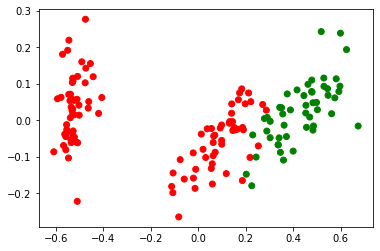

In [7]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors)
plt.show()

In [8]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

We keep only 33% of the dataset as test set.

We shuffle and stratify, since the outliers are not the same amount as the regular points.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, shuffle=True, stratify=y)

In [10]:
params = {
    'q': randint(0, 500),
    'c': uniform()    
}
clf = RandomizedSearchCV(BSVClassifier(), params, cv=5, n_jobs=-1, refit='f1', verbose=10, return_train_score=False, n_iter=100)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1916s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1640s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:    3.9s
[Parallel(n_jo

Academic license - for non-commercial use only - expires 2021-06-25
Using license file /Users/maxfrax/gurobi.lic
Changed value of parameter ObjScale to -0.5
   Prev: 0.0  Min: -1.0  Max: inf  Default: 0.0
Changed value of parameter NumericFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 33 columns and 33 nonzeros
Model fingerprint: 0x4edb303f
Model has 561 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [8e-01, 4e+00]
  Bounds range     [8e-01, 8e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 33 columns, 33 nonzeros
Presolved model has 561 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 s

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.3s finished


RandomizedSearchCV(cv=5, estimator=BSVClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'c': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa250059af0>,
                                        'q': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa250059820>},
                   refit='f1', verbose=10)

In [11]:
y_pred = clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y_test, y_pred)}')
print(f'Recall {recall_score(y_test, y_pred)}')
print(f'F1 {f1_score(y_test, y_pred)}')
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

Precision 0.9705882352941176
Recall 1.0
F1 0.9850746268656716
Accuracy 0.98


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.97      1.00      0.99        33

    accuracy                           0.98        50
   macro avg       0.99      0.97      0.98        50
weighted avg       0.98      0.98      0.98        50



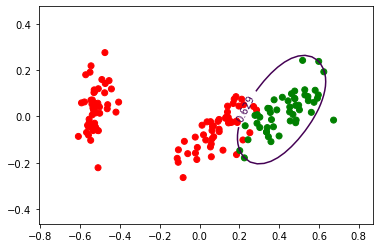

In [14]:
best_clf = clf.best_estimator_

gx = np.linspace(min(X_reduced[:,0])-.2, max(X_reduced[:,0])+.2, 50)
gy = np.linspace(min(X_reduced[:,1])-.2, max(X_reduced[:,1])+.2, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([best_clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(best_clf.radius_, ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=colors)
plt.show()

In [15]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

# Nested Cross validation

Once found the best hyper params each training set, how good and consistent are the metrics?

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, LeaveOneOut


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA()),
        ('classifier', BSVClassifier())
])

params = {
    'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'reduce_dim__n_components': randint(0, X.shape[1]),
    'classifier__q': randint(0, 500),
    'classifier__c': uniform()    
}

scoring = ['precision', 'recall', 'f1']

Inner loop aka RandomizedSearchCV to find the best model given the data.
Outer loop to see if the best model was just lucky or all the best models perform well.

In [17]:
outer_cv = StratifiedKFold(n_splits=10, shuffle=True)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)


r_clf = RandomizedSearchCV(pipe, params, n_jobs=-1, cv=inner_cv, refit='f1', verbose=10, return_train_score=False, scoring=scoring, n_iter=100)
scores = cross_validate(r_clf, X=X, y=y, cv=outer_cv, n_jobs=-1, scoring=scoring, verbose=10, return_estimator=True, return_train_score=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.3min remaining:   34.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.5min finished


In [18]:
import pandas as pd

cv_res = pd.DataFrame(scores)
cv_res['estimator_params'] = [est.best_params_ for est in cv_res['estimator']]
cv_res = cv_res.dropna()

cv_res

,fit_time,score_time,estimator,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,estimator_params
0,79.725776,0.006570,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.977273,0.8,0.955556,0.888889,0.966292,"{'classifier__c': 0.17696066033622415, 'classi..."
2,79.797501,0.006917,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.988235,1.0,0.933333,1.000000,0.960000,"{'classifier__c': 0.3467361894529877, 'classif..."
3,79.050620,0.006297,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.976744,1.0,0.933333,1.000000,0.954545,"{'classifier__c': 0.949013176380314, 'classifi..."
4,80.111701,0.007602,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.900000,0.955056,0.9,0.944444,0.900000,0.949721,"{'classifier__c': 0.4543498764805012, 'classif..."
5,78.599621,0.006056,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.955056,0.9,0.944444,0.947368,0.949721,"{'classifier__c': 0.8687777401516811, 'classif..."
6,79.000381,0.006215,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.967033,0.9,0.977778,0.947368,0.972376,"{'classifier__c': 0.0731412707338146, 'classif..."
7,77.272224,0.006309,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,1.000000,0.965116,0.9,0.922222,0.947368,0.943182,"{'classifier__c': 0.10537630104694595, 'classi..."
8,70.733849,0.006380,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.909091,0.965116,1.0,0.922222,0.952381,0.943182,"{'classifier__c': 0.9214910548076831, 'classif..."
9,69.973819,0.006561,RandomizedSearchCV(cv=StratifiedKFold(n_splits...,0.833333,0.977528,1.0,0.966667,0.909091,0.972067,"{'classifier__c': 0.11960541189440665, 'classi..."


In [19]:
print(f'Average precision: {np.average(cv_res["test_precision"]):.4f}')
print(f'Std precision: {np.std(cv_res["test_precision"]):.4f}')

print(f'\nAverage recall: {np.average(cv_res["test_recall"]):.4f}')
print(f'Std recall: {np.std(cv_res["test_recall"]):.4f}')

print(f'\nAverage f1: {np.average(cv_res["test_f1"]):.4f}')
print(f'Std f1: {np.std(cv_res["test_f1"]):.2f}')

Average precision: 0.9603
Std precision: 0.0595

Average recall: 0.9333
Std recall: 0.0667

Average f1: 0.9436
Std f1: 0.04


In [20]:
ix = cv_res['test_f1'].idxmax()

cv_res['estimator_params'][ix]

{'classifier__c': 0.3467361894529877,
 'classifier__q': 13,
 'reduce_dim__n_components': 1,
 'scaler': MaxAbsScaler()}